# Чтение данных

In [1]:
ROOT_DIR = '3-Full-Cycles 275-295 gallons'

### Вспомогательные методы для чтения и разбора данных

In [34]:
import os
import itertools
import pandas as pd
import numpy as np
import datetime
import re


def parse_datetime(line):
    return datetime.datetime.strptime(line[5:], '%Y-%m-%d %H:%M:%S.%f')


def parse_temperature(line):
    return float(line[14:-3])


def parse_pressure(line):
    return float(line[22:-5])


def parse_battery_voltage(line):
    return float(line[24:-6])


def parse_pot_setting(line):
    values = re.sub(r'[A-z;=>:]', ' ', line.replace('POT1', '').replace('POT2', '')).split()
    return map(float, values)

def parse_gallons(gal_dir_name):
    return float(re.sub(r'[^\d]', '', gal_dir_name))


def yield_gallon_dir(sample_dir, root_dir=ROOT_DIR):
    gallons = parse_gallons(sample_dir)
    sample_files = os.listdir(os.path.join(root_dir, sample_dir))
    for sample_file in sample_files:
        with open(os.path.join(root_dir, sample_dir, sample_file)) as f:
            lines = map(lambda l: l[:-1], f)
            pot_values = parse_pot_setting(lines[4])
            yield {
                'gallons': gallons,
                'datetime': parse_datetime(lines[0]),
                'temperature': parse_temperature(lines[1]),
                'pressure': parse_pressure(lines[2]),
                'battery_voltage': parse_battery_voltage(lines[3]),
                'pot_setting1': pot_values[0],
                'pot_setting2': pot_values[1],
                'pot_setting3': pot_values[2],
                'sample': np.array(map(int, lines[5:]))
            } 

### Непосредственно чтение данных

In [3]:
samples_dirs = filter(lambda d: d.endswith('gal'), os.listdir(ROOT_DIR))


samples_df = pd.DataFrame(list(
    itertools.chain.from_iterable((yield_gallon_dir(d) for d in samples_dirs))
))

print samples_df.shape
samples_df.sample(10)

(1260, 9)


,battery_voltage,datetime,gallons,pot_setting1,pot_setting2,pot_setting3,pressure,sample,temperature
944,6.00,2016-01-12 20:47:54.296762,282,192,127,12.5,28.67,"[971, 4095, 1649, 3638, 1825, 1051, 2588, 4095...",8.6
1118,6.23,2016-01-15 15:11:08.699000,275,192,127,12.5,28.45,"[563, 1261, 406, 4095, 1421, 3164, 1592, 2197,...",12.8
589,5.91,2016-01-12 22:17:47.516355,287,192,127,12.5,28.73,"[63, 4095, 1915, 2158, 91, 1258, 2342, 3768, 1...",8.4
1049,6.04,2016-01-14 19:38:33.256629,284,192,127,12.5,28.65,"[2052, 3094, 1536, 2646, 2492, 4095, 62, 4095,...",12.6
36,6.25,2016-01-12 23:56:13.175695,290,192,127,12.5,28.82,"[62, 4095, 169, 2650, 2473, 1084, 3194, 2419, ...",7.3
227,6.05,2016-01-14 19:16:09.832667,283,192,127,12.5,28.65,"[4095, 4095, 67, 68, 1419, 2725, 2193, 1817, 2...",11.9
170,6.13,2016-01-14 17:17:24.455229,278,192,127,12.5,28.69,"[3266, 575, 2592, 3454, 2129, 503, 2483, 2457,...",11.5
161,6.14,2016-01-14 17:22:57.663408,278,192,127,12.5,28.70,"[467, 66, 4095, 1400, 3048, 969, 2525, 455, 40...",11.7
750,6.00,2016-01-14 21:50:18.829062,288,192,127,12.5,28.66,"[2987, 3393, 585, 3390, 1576, 2695, 1783, 220,...",13.0
690,6.03,2016-01-12 19:38:27.474759,277,192,127,12.5,28.61,"[3619, 1568, 3132, 1228, 81, 2779, 4053, 1771,...",9.9


In [4]:
samples_mat = np.vstack(samples_df['sample'].values)
samples_mat.shape

(1260, 16384)

### График трех случайных сэмплов

/home/obus/.venv/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy


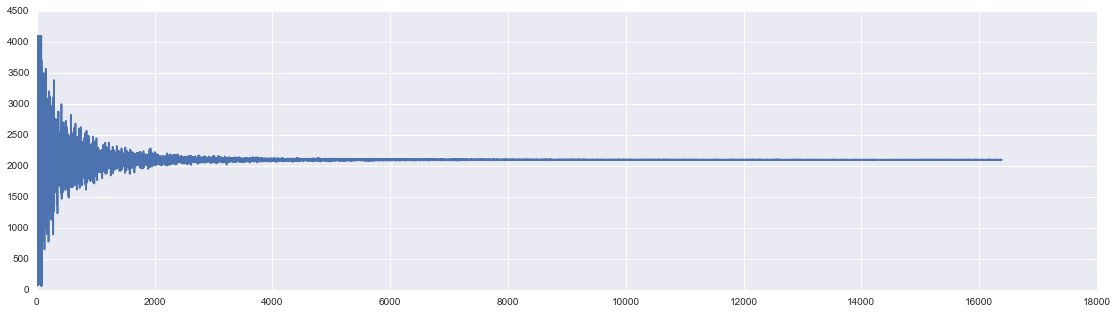

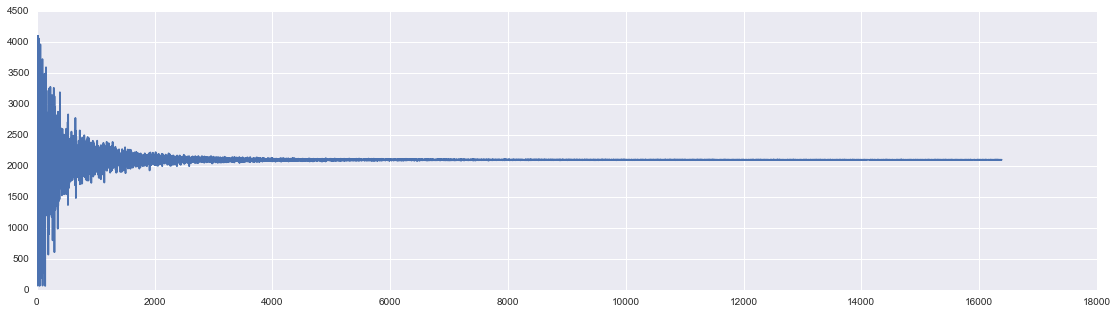

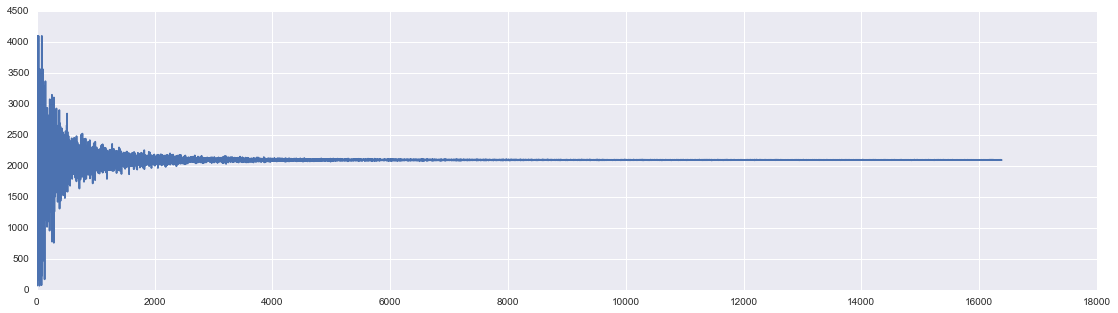

In [5]:
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 5)

for i in np.random.choice(range(samples_mat.shape[0]), 3, replace=False):
    plt.plot(samples_mat[i,:])
    plt.show()

# Предсказание gallons

In [6]:
import scipy as sp


def list_to_matrix(list_like):
    if sp.sparse.issparse(list_like[0]):
        return sp.sparse.vstack(list_like)
    else:
        return np.vstack(list_like)

    

def vectorize(df):
    df_columns = [df.ix[:, i].values for i in range(df.shape[1])]
    df_matrixes = map(list_to_matrix, df_columns)

    if any([sp.sparse.issparse(m) for m in df_matrixes]):
        X = sp.sparse.hstack(df_matrixes).tocsr()
    else:
        X = np.hstack(df_matrixes)
    return X


In [7]:
import sklearn
import sklearn.cross_validation
import sklearn.linear_model
import sklearn.metrics

In [38]:
def regression_report(model, X, y):
    y_pred = model.predict(X)
    
    print '\t MSE: {:.2f}'.format(sklearn.metrics.mean_squared_error(y, y_pred))
    print '\t MAE: {:.2f}'.format(sklearn.metrics.mean_absolute_error(y, y_pred))
    
    
def regression_report_train_valid(model, X_train, X_valid, y_train, y_valid, fit=True):
    if fit==True:
        model.fit(X_train, y_train)
    print 'Train:'
    regression_report(model, X_train, y_train)
    print 'Valid:'
    regression_report(model, X_valid, y_valid)
    
    y_valid_pred = model.predict(X_valid)
    plt.figure(figsize=(6, 4))
    sns.distplot(y_valid - y_valid_pred, bins=40, label='AAA', axlabel='Validation residuals')

## Модели на без учета данных sample

In [13]:
features_names = ['battery_voltage','pot_setting1','pot_setting2','pot_setting3','pressure','temperature']
X_raw = samples_df[features_names]

X = vectorize(X_raw)
y = samples_df.gallons.values

X_train, X_valid, y_train, y_valid = sklearn.cross_validation.train_test_split(
    X, y, train_size=0.7, random_state=419)
print 'Train size: {0}, validation size: {1}'.format(X_train.shape[0], X_valid.shape[0])

Train size: 882, validation size: 378


### Linear regression

Train:
	 MSE: 35.15
	 MAE: 5.06
Valid:
	 MSE: 37.12
	 MAE: 5.29


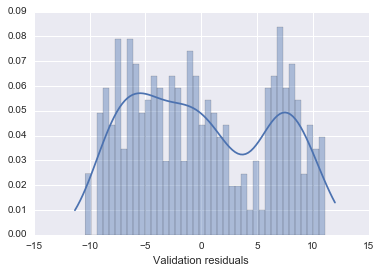

In [42]:
model = sklearn.linear_model.LinearRegression(
    copy_X=True, fit_intercept=True, n_jobs=1, normalize=False
)

regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

#### Коэффициенты

In [43]:
print '{:+.03f}'.format(model.intercept_), '\t', 'intercept'

for feature, coef in sorted(zip(features_names, model.coef_), key=lambda kv: -abs(kv[1])):
    print '{:+.03f}'.format(coef), '\t', feature

+322.703 	intercept
-9.811 	battery_voltage
+0.761 	pressure
+0.001 	temperature
+0.000 	pot_setting1
+0.000 	pot_setting2
+0.000 	pot_setting3


### Suppor Vector Regression (rbf kernel, default parameters)

Train:
	 MSE: 28.18
	 MAE: 3.48
Valid:
	 MSE: 30.31
	 MAE: 3.55


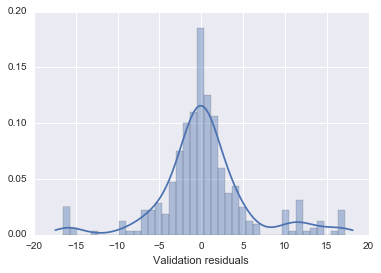

In [44]:
model = sklearn.svm.SVR(kernel='rbf')#, C=1e3, gamma=0.1)

regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

### Suppor Vector Regression (rbf kernel, parameters estimated by grid search cross-validation)

In [45]:
model = sklearn.grid_search.GridSearchCV(
    estimator=sklearn.svm.SVR(),
    param_grid={
        'kernel': ['rbf'],
        'C': [4**i for i in range(-5, 5)],
        'gamma': [4**i for i in range(-5, 5)],
        'cache_size': [1]
    },
    refit=True,
    n_jobs=4,
    cv=5,
    verbose=True
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   16.1s finished


Train:
	 MSE: 0.79
	 MAE: 0.47
Valid:
	 MSE: 0.62
	 MAE: 0.51


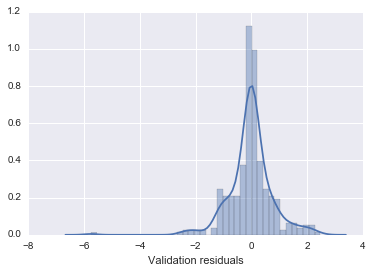

In [46]:
regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

In [47]:
model.best_params_

{'C': 256, 'cache_size': 1, 'gamma': 4, 'kernel': 'rbf'}

In [48]:
# import sys
# bytes_sizes = []
# for attr in dir(model.best_estimator_):
#     try:
#         bytes = sys.getsizeof(getattr(model.best_estimator_, attr))
#         print attr, '\t', bytes
#         bytes_sizes.append(bytes)
#     except:
#         print 'Failed at', attr
        
# print np.sum(bytes_sizes)

# Проверка модели на данных 2015-12-21-OrangeTank

## Чтение данных

In [36]:
TEST_ROOT_DIR = '2015-12-21-OrangeTank'

test_samples_dirs = filter(lambda d: 'Gallon' in d, os.listdir(TEST_ROOT_DIR))


test_samples_df = pd.DataFrame(list(
    itertools.chain.from_iterable((yield_gallon_dir(d, TEST_ROOT_DIR) for d in test_samples_dirs))
))

print test_samples_df.shape
test_samples_df.sample(10)

(3734, 9)


,battery_voltage,datetime,gallons,pot_setting1,pot_setting2,pot_setting3,pressure,sample,temperature
3584,5.84,2015-12-24 17:31:02.535500,155,192,127,12.5,28.85,"[1350, 3388, 1337, 2196, 65, 3451, 1789, 3867,...",19.6
3714,5.90,2015-12-24 17:41:36.319087,155,192,127,12.5,28.86,"[4014, 799, 2146, 2026, 3016, 1227, 1596, 71, ...",20.0
361,6.17,2015-12-24 05:22:36.673267,215,192,127,12.5,28.30,"[2235, 790, 4095, 4095, 1406, 623, 3228, 1203,...",23.8
716,5.95,2015-12-22 06:43:32.625298,275,192,127,12.5,28.69,"[2738, 3624, 174, 1883, 62, 4006, 1224, 3711, ...",22.5
806,5.95,2015-12-22 21:24:56.463396,275,192,127,12.5,28.80,"[217, 559, 1710, 4095, 64, 2278, 2710, 879, 20...",22.8
1132,5.83,2015-12-23 01:09:47.453722,275,192,127,12.5,28.84,"[1328, 1074, 3323, 2984, 3389, 274, 3067, 2665...",22.5
3623,5.91,2015-12-24 17:22:09.869436,155,192,127,12.5,28.85,"[3570, 772, 2541, 1385, 3366, 1434, 2069, 65, ...",19.3
1946,5.87,2015-12-22 23:41:59.577062,275,192,127,12.5,28.84,"[4095, 64, 130, 4095, 4071, 2112, 792, 3709, 3...",22.7
177,5.99,2015-12-28 00:22:13.720824,215,192,127,12.5,29.23,"[1999, 3476, 4095, 543, 1467, 4095, 520, 944, ...",17.7
1927,5.93,2015-12-22 04:28:08.398107,275,192,127,12.5,28.71,"[4095, 723, 1335, 4095, 1770, 866, 115, 1562, ...",22.2


In [39]:
X_test = vectorize(test_samples_df[features_names])
y_test = test_samples_df.gallons.values

## Проверка моделей

### Linear regression

In [56]:
model = sklearn.linear_model.LinearRegression(
    copy_X=True, fit_intercept=True, n_jobs=1, normalize=False
)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Train:
	 MSE: 37.12
	 MAE: 5.29
Valid:
	 MSE: 5421.94
	 MAE: 46.62


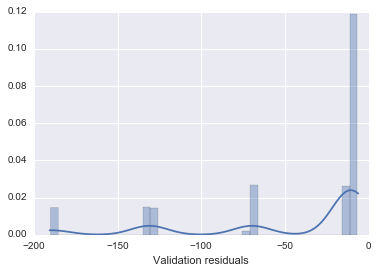

In [57]:
regression_report_train_valid(model, X_valid, X_test, y_valid, y_test, fit=False)

### Suppor Vector Regression (rbf kernel, parameters estimated by grid search cross-validation)

In [58]:
model = sklearn.grid_search.GridSearchCV(
    estimator=sklearn.svm.SVR(),
    param_grid={
        'kernel': ['rbf'],
        'C': [4**i for i in range(-5, 5)],
        'gamma': [4**i for i in range(-5, 5)],
        'cache_size': [1]
    },
    refit=True,
    n_jobs=4,
    cv=5,
    verbose=True
)
model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   16.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'cache_size': [1], 'kernel': ['rbf'], 'C': [0.0009765625, 0.00390625, 0.015625, 0.0625, 0.25, 1, 4, 16, 64, 256], 'gamma': [0.0009765625, 0.00390625, 0.015625, 0.0625, 0.25, 1, 4, 16, 64, 256]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

Train:
	 MSE: 0.62
	 MAE: 0.51
Valid:
	 MSE: 5144.70
	 MAE: 45.74


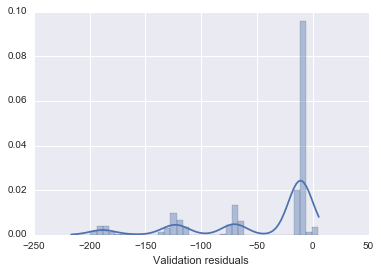

In [59]:
regression_report_train_valid(model, X_valid, X_test, y_valid, y_test, fit=False)

Train:
	 MSE: 5144.70
	 MAE: 45.74
Valid:
	 MSE: 123.31
	 MAE: 10.91


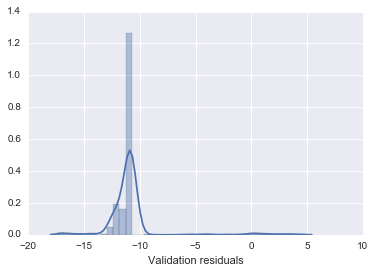

In [71]:
regression_report_train_valid(model, X_test, X_test[y_test > 250,:], y_test, y_test[y_test > 250], fit=False)